TODO: `search_recent_tweets` is up to 7 days. To search further back, use [search_all_tweets](https://docs.tweepy.org/en/stable/client.html#tweepy.Client.search_all_tweets) instead (and add `start_time` parameter). But it needs the [academic research access](https://developer.twitter.com/en/docs/projects). It also increases the monthly cap from 500,000 to 10 million, `max_results` from 100 to 500, and allows to use `-is:nullcast ` to filter out some ads.

In [26]:
from datetime import datetime, timezone, timedelta
from collections import defaultdict
from time import time
import json
import os
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tweepy

In [2]:
#TODO tune
bearer_token = "AAAAAAAAAAAAAAAAAAAAAH4BlAEAAAAA3Dd4SGtdK%2FWbAqlEdIcXzoPB4%2BA%3DwDjEbymhTQgnmvHM8Vvetae79bgdBz1eyHWSyXZVqRnCCir1nA" #mpolo
limit = 200 #number of requests of `max_results` tweets each

#create paginator
client = tweepy.Client(bearer_token)
paginator = tweepy.Paginator(
    method = client.search_recent_tweets,
    limit = limit,
    query = (
        '(context:131.825047692124442624 OR context:152.825047692124442624) ' #https://github.com/twitterdev/twitter-context-annotations
        '-is:retweet ' #only original tweets
        '-is:reply '
        '-is:quote '
        '-has:links ' #no tweets with embedded images etc.
        '-has:media '
        'lang:en'),
    end_time = (datetime.now(timezone.utc)-timedelta(days=6)).isoformat(), #go backwards from 6 days ago
    expansions = ['author_id'],
    max_results = 100,
    tweet_fields = ['public_metrics'],
    user_fields = ['public_metrics'])

#download tweets
data = defaultdict(list)
for response in paginator:
    for tweet, user in zip(response.data, response.includes['users']):
        if tweet.author_id == user.id: #some don't match for no reason
            data['text'] += [tweet.text]
            data['likes'] += [tweet.public_metrics['like_count']]
            data['impressions'] += [tweet.public_metrics['impression_count']]
            data['followers'] += [user.public_metrics['followers_count']]

#save raw tweets
dir_ = f'debug_sets/{int(time() % 1e6)}/' #unique for 11 days
os.makedirs(dir_)
pd.DataFrame(data).to_csv(dir_+'dataset_raw.csv', index=False)
with open(dir_+'metadata.json', mode='w') as fp:
    json.dump(paginator.kwargs, fp)
dir_

'debug_sets/710527/'

In [72]:
#load raw tweets
df = pd.read_csv(dir_+'dataset_raw.csv')

#start likes and impressions from 1 for simplicity
df['likes'] += 1
df['impressions'] += 1
df.tail(2)

,text,likes,impressions,followers
7803,Guinness Blonde $1.80 per oz of alcohol. #boo...,1.0,19.0,14.0
7804,Fundraising to send food trucks with coffee an...,106.0,4199.0,2077.0


0.0007411884264423407

0.4251956098145834

0.07276196523743456

32.587028495334756

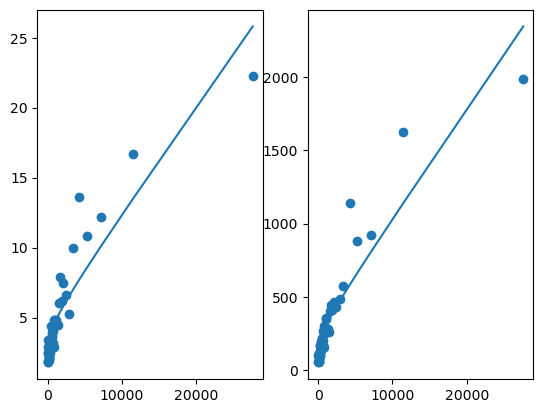

In [79]:
#TODO tune
q_order = 0.99 #quantile order
num_groups = 50 #number of groups

#remove outliers from data to plot
q = df.quantile(q_order, numeric_only=True) #numeric_only to fix warning
df_q = df[
    (df['likes'] < q['likes']) &
    (df['impressions'] < q['impressions']) &
    (df['followers'] < q['followers'])].copy() #copy to fix warning

#group by followers
df_q.sort_values(by='followers', inplace=True, ignore_index=True)
df_q['group'] = df_q.index//(len(df_q)/num_groups) #groups of same size
df_q = df_q.groupby('group').mean(numeric_only=True) #numeric_only to fix warning

#plot average likes vs average followers
x = df_q['followers']
y = df_q['likes']
fig, axs = plt.subplots(1, 2)
axs[0].scatter(x, y)
#axs[0].xlabel('average followers')
#axs[0].ylabel('average likes')

#fit curve and plot it
def curve(x, a, b):
    return 1 + a*x + b*np.log(1+x)
(a, b), _ = curve_fit(curve, xdata=x, ydata=y)
axs[0].plot(x, curve(x, a, b))
display(a, b)

#plot average impressions vs average followers
y = df_q['impressions']
axs[1].scatter(x, y)
#axs[1].xlabel('average followers')
#axs[1].ylabel('average likes')

#fit curve and plot it
def curve(x, c, d):
    return 1 + c*x + d*np.log(1+x)
(c, d), _ = curve_fit(curve, xdata=x, ydata=y)
axs[1].plot(x, curve(x, c, d))
display(c, d)

In [78]:
#TODO tune
lower = 0.5 #lower bound for medium popularity
upper = 2 #upper bound for medium popularity

#get popularity by normalizing metrics
df['like_pop'] = df['likes']/curve(df['followers'], a, b) #likes starts from 1
df['like_pop_level'] = df['like_pop'].apply(lambda x: 0 if x<lower else 1 if x<upper else 2)
df['impr_pop'] = df['impressions']/curve(df['followers'], c, d) #impressions starts from 1
df['impr_pop_level'] = df['impr_pop'].apply(lambda x: 0 if x<lower else 1 if x<upper else 2)

#prevent a low pop tweet with 0 likes from being labeled as medium pop if it hasn't enough followers
df = df[(df['likes']>1) | (1/curve(df['followers'], a, b)<lower)]
#prevent a low pop tweet with 0 impressions from being labeled as medium pop if it hasn't enough followers
df = df[(df['impressions']>1) | (1/curve(df['followers'], a, b)<lower)]

#set likes and impressions back to the original values #TODO
df_pop = df.copy() #new dataframe for robustness against multiple cell execution
df_pop['likes'] -= 1
df_pop['impressions'] -= 1

#save tweets with popularity 
df_pop.to_csv(dir_+'dataset_pop.csv', index=False)
df_pop.sample(2)

,text,likes,impressions,followers,like_pop,like_pop_level,impr_pop,impr_pop_level
7528,"Breakfast at the redneck corral, the farmers m...",1.0,84.0,136.0,0.939334,1,0.910766,1
5031,“Having a yummy lunch along with great coffee....,0.0,13.0,228.0,0.439146,0,0.130672,0
